<a href="https://www.kaggle.com/code/klyushnik/stack-classification-loan-approval-prediction?scriptVersionId=199705019" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# Description

![images?q=tbn:ANd9GcQ98aMxgAztfFGsqdOjMm3JKKOWjPj1e_UIrxFY3UYjQ0S92yqYgGH4rINdvLIKOGz70Gc&usqp=CAU](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ98aMxgAztfFGsqdOjMm3JKKOWjPj1e_UIrxFY3UYjQ0S92yqYgGH4rINdvLIKOGz70Gc&usqp=CAU)

"In finance, a loan is the transfer of money by one party to another with an agreement to pay it back. The recipient, or borrower, incurs a debt and is usually required to pay interest for the use of the money."


**The Loan Process**
Here's how the loan process works: When someone needs money, they apply for a loan from a bank, corporation, government, or other entity. The borrower may be required to provide specific details such as the reason for the loan, their financial history, Social Security number (SSN), and other information. The lender reviews this information as well as a person's debt-to-income (DTI) ratio to determine if the loan can be paid back.
1
Wells Fargo Bank. "How To Get A Loan From A Bank."

Based on the applicant's creditworthiness, the lender either denies or approves the application. The lender must provide a reason should the loan application be denied. If the application is approved, both parties sign a contract that outlines the details of the agreement. The lender advances the proceeds of the loan, after which the borrower must repay the amount including any additional charges, such as interest.

The terms of a loan are agreed to by each party before any money or property changes hands or is disbursed. If the lender requires collateral, the lender outlines this in the loan documents. Most loans also have provisions regarding the maximum amount of interest, in addition to other covenants, such as the length of time before repayment is required.

Resource:https://www.investopedia.com/terms/l/loan.asp

# Welcome

Welcome to my github - https://github.com/Alexsandrrus/projekts-Kaggle

# libraries

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, 
                                    StandardScaler, MinMaxScaler, LabelEncoder,
                                   MinMaxScaler, RobustScaler)
from sklearn.metrics import (roc_auc_score, confusion_matrix,
                            roc_curve, auc, accuracy_score, make_scorer,
                            RocCurveDisplay, classification_report)

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV

# from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder

from tabulate import tabulate

import optuna
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import lightgbm as lgb
import xgboost as xgb

from mlxtend.classifier import StackingCVClassifier 

import catboost
from catboost import *
from catboost import CatBoostClassifier

import itertools

import warnings

warnings.filterwarnings("ignore")

In [3]:
def plot_box_hist(x):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    sns.boxplot(x=x, ax=ax_box)
    sns.histplot(x=x, bins=12, kde=True, stat='density', ax=ax_hist)

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    return plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

def apply_remove_outliers_iqr(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    for column in numeric_columns:
        df = remove_outliers_iqr(df, column)
    return df

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')
    
    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1 : (len(lines) - 4)]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().replace(' avg', '-avg').split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]
    
    plt.figure(figsize=(10,10))

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.tight_layout()

# CSV

In [4]:
train = pd.read_csv("/kaggle/input/playground-series-s4e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e10/test.csv")

print('Shape train is', train.shape, 'shape test is', test.shape)

Shape train is (58645, 13) shape test is (39098, 12)


In [5]:
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

id - 0%
person_age - 0%
person_income - 0%
person_home_ownership - 0%
person_emp_length - 0%
loan_intent - 0%
loan_grade - 0%
loan_amnt - 0%
loan_int_rate - 0%
loan_percent_income - 0%
cb_person_default_on_file - 0%
cb_person_cred_hist_length - 0%
loan_status - 0%


In [6]:
train.duplicated().sum()

0

# Analytics

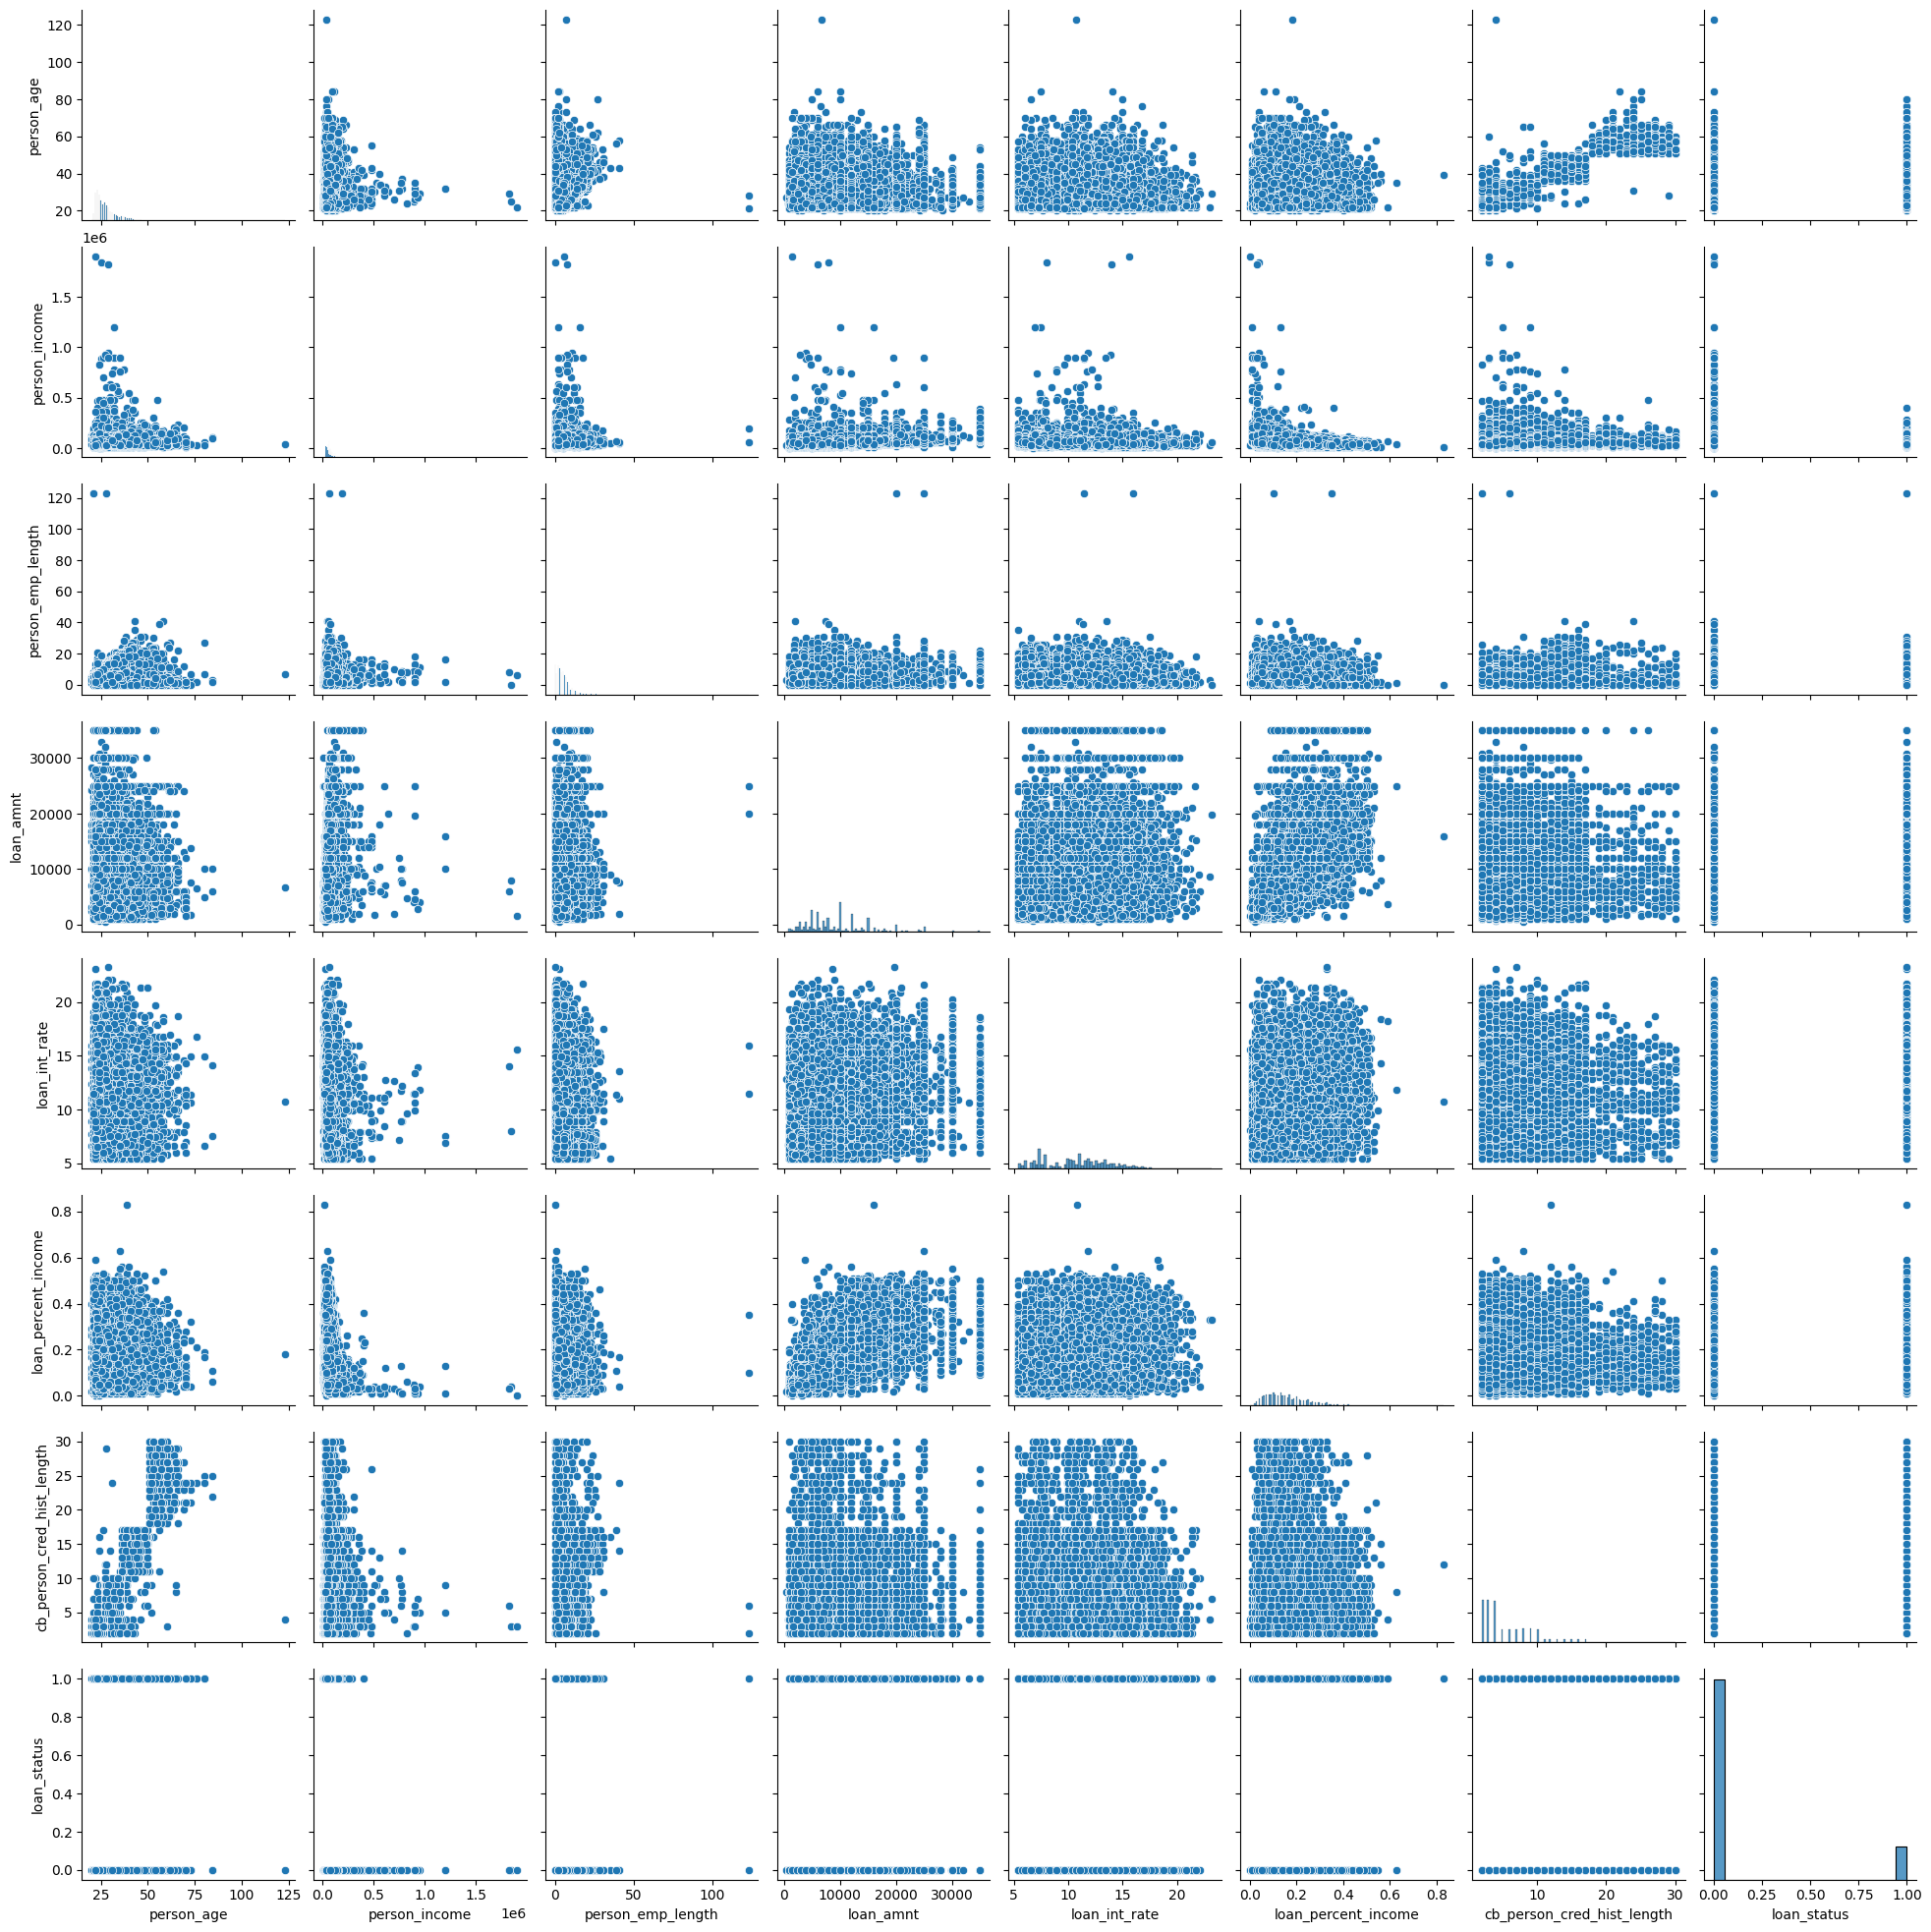

In [7]:
sns.pairplot(train.drop(['id'], axis=1))

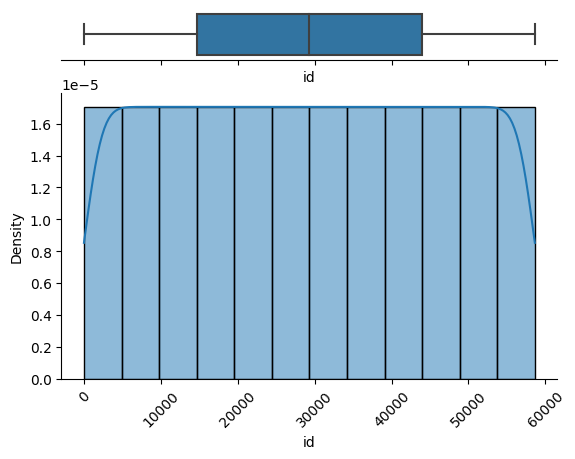

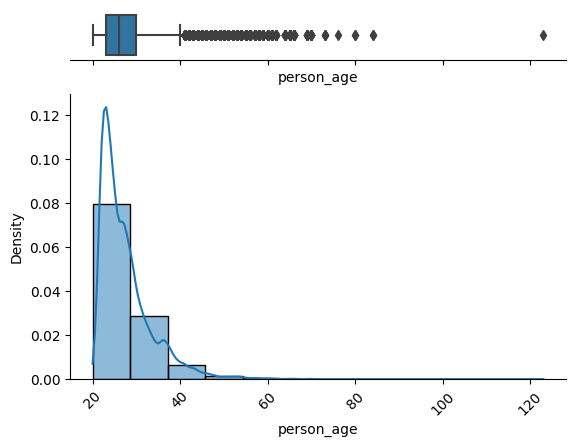

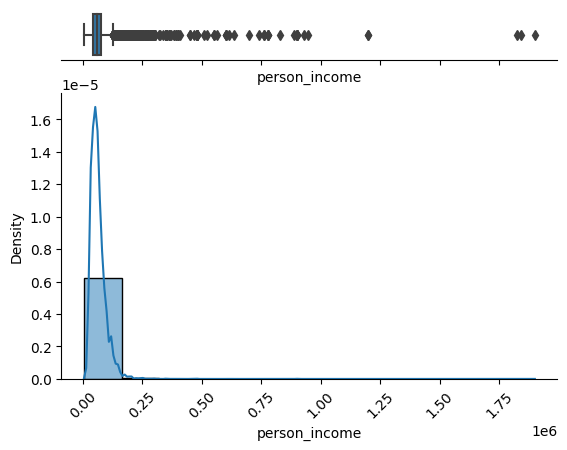

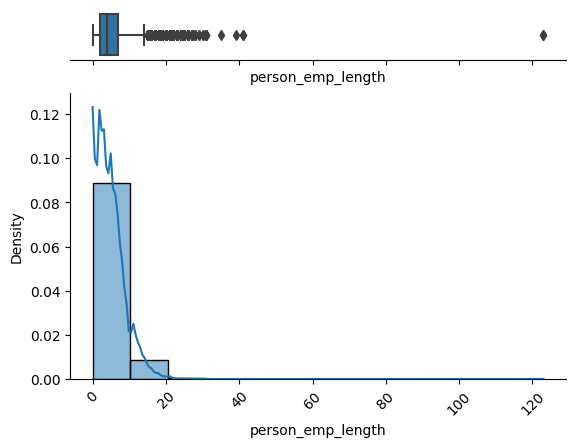

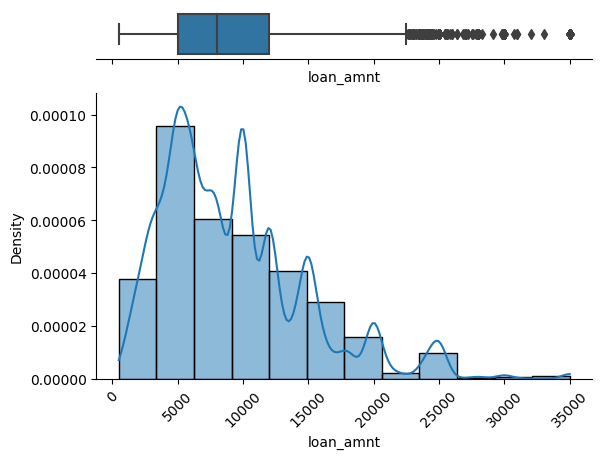

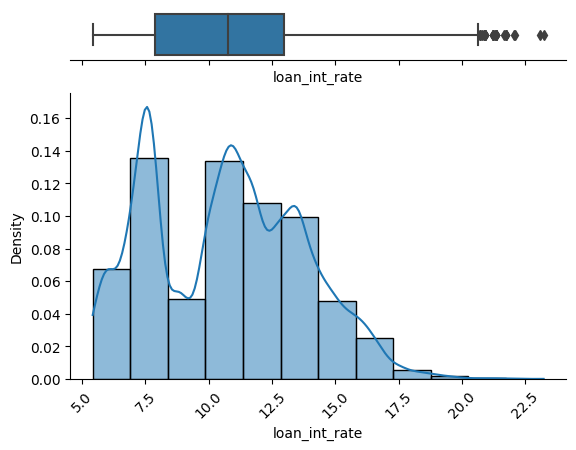

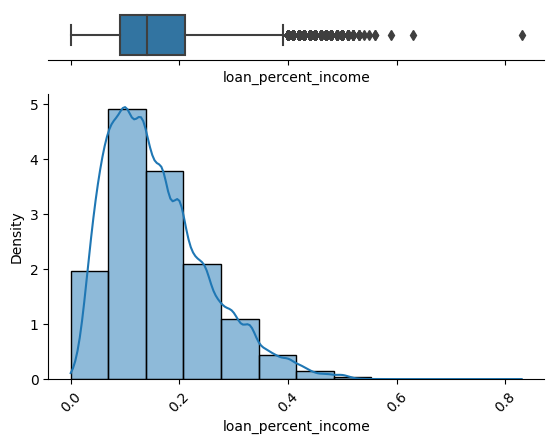

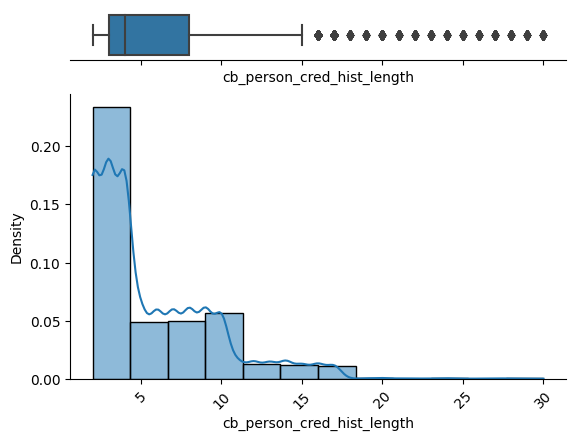

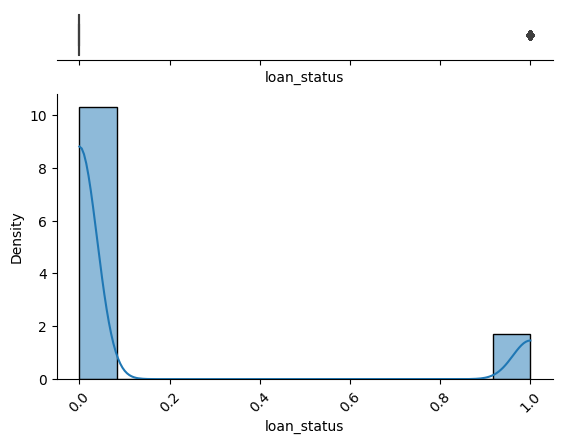

In [8]:
num_feature = train.select_dtypes(include=[np.number]).columns
for i in num_feature:
    plot_box_hist(train[i])

**There are outliers, we will return to them a little later. It is necessary to turn to quantile constructions and the correlation component to see how the data is distributed**

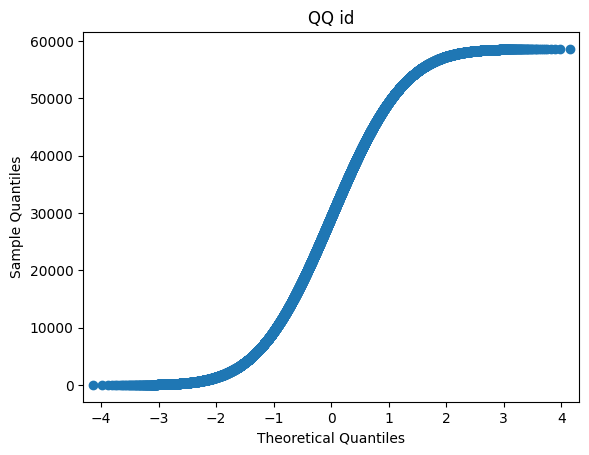

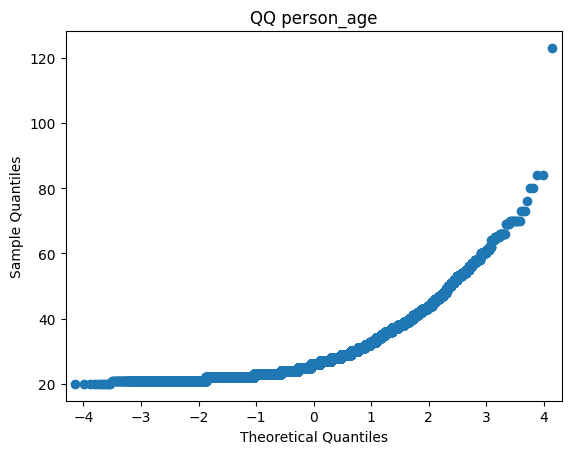

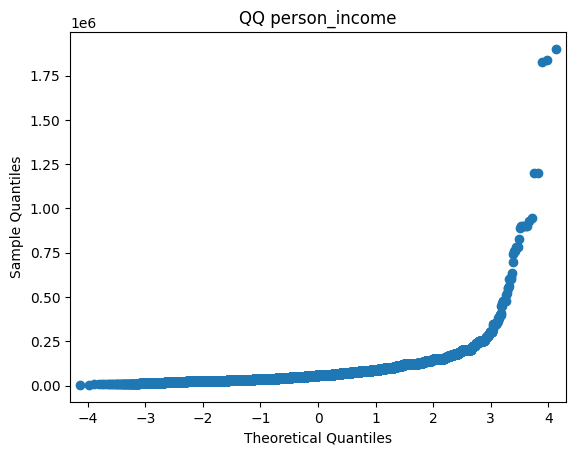

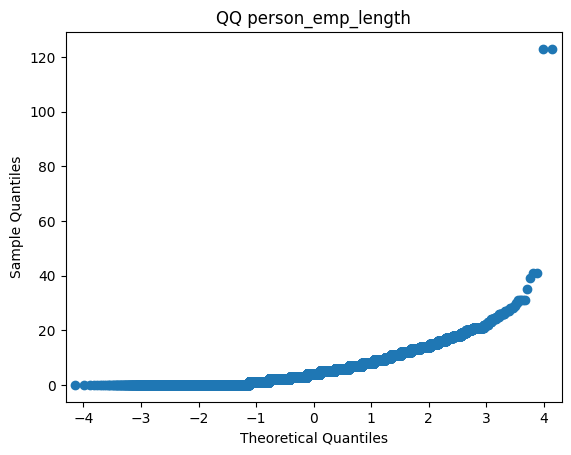

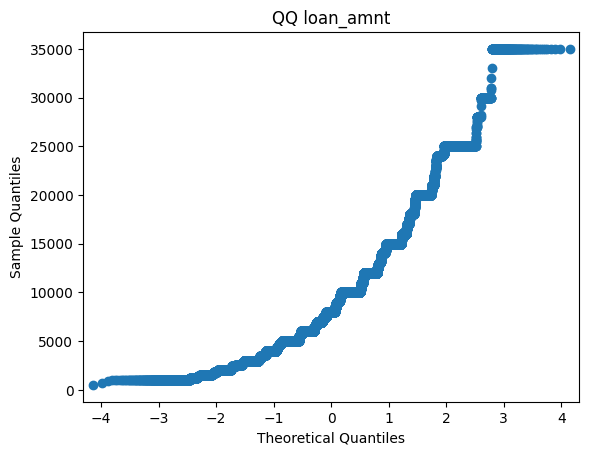

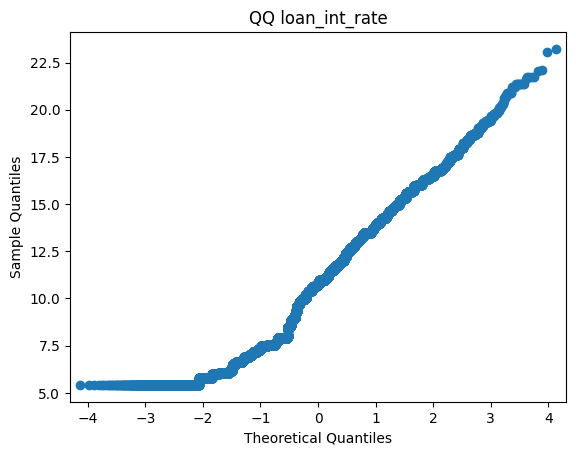

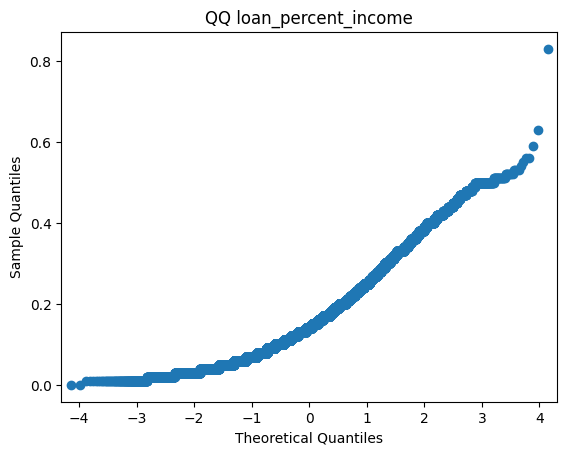

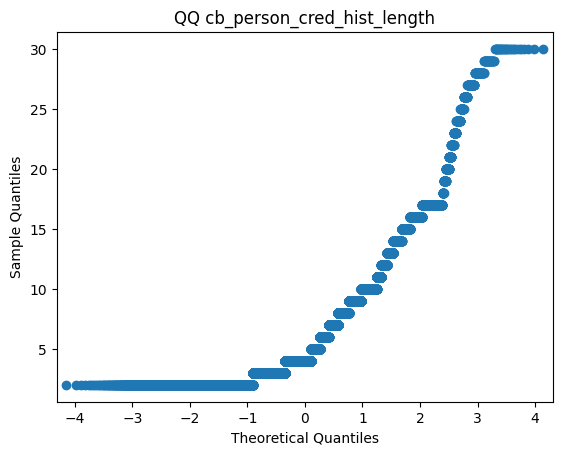

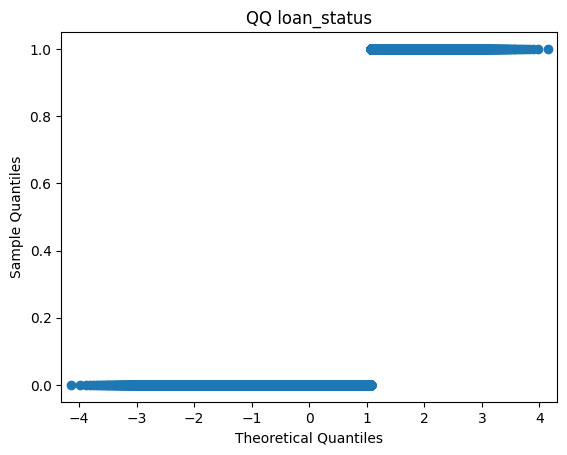

In [9]:
for i in num_feature:
    sm.qqplot(train[i])
    plt.title(f'QQ {i}')
    plt.show()

**It may be necessary to transform the data into a normal state, logarithm it, square it**

In [10]:
X = sm.add_constant(train.select_dtypes(include=[np.number]))

# расчет VIF для каждого предиктора
print('calculation of VIF for each predictor')
print()
VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

calculation of VIF for each predictor

                     Variable        VIF
0                       const  74.747203
1                          id   1.000188
2                  person_age   4.275980
3               person_income   1.998349
4           person_emp_length   1.061715
5                   loan_amnt   3.255509
6               loan_int_rate   1.146970
7         loan_percent_income   3.442256
8  cb_person_cred_hist_length   4.244769
9                 loan_status   1.325767


**High VIF values ​​indicate potential multicollinearity problems. In general, a VIF value above 5 requires attention, and above 10 requires serious consideration of changes to the model. In our case, we will work without removing features.**

**Everything is fine**

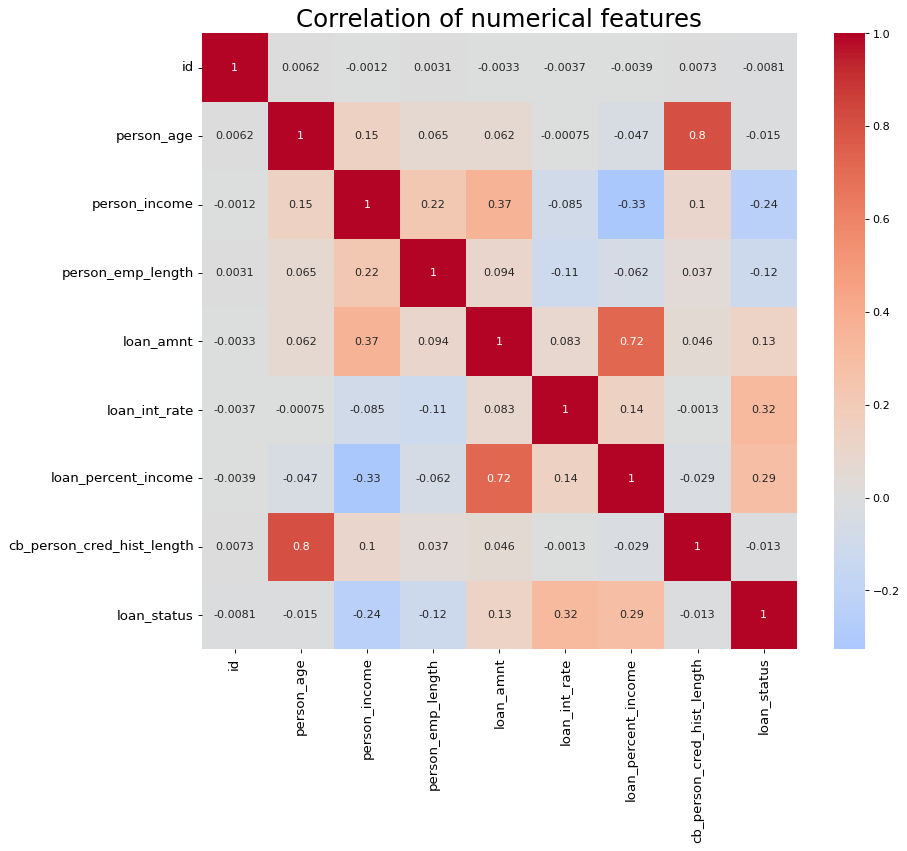

In [11]:
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(train.select_dtypes(include=[np.number]).corr('spearman'),
            xticklabels=train.select_dtypes(include=[np.number]).columns,
            yticklabels=train.select_dtypes(include=[np.number]).columns, 
            cmap='coolwarm', center=0, annot=True)

# Decorations
plt.title('Correlation of numerical features', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

**The dataset contains negative, weakly negative and weakly positive correlation of features, and strongly positive correlation**

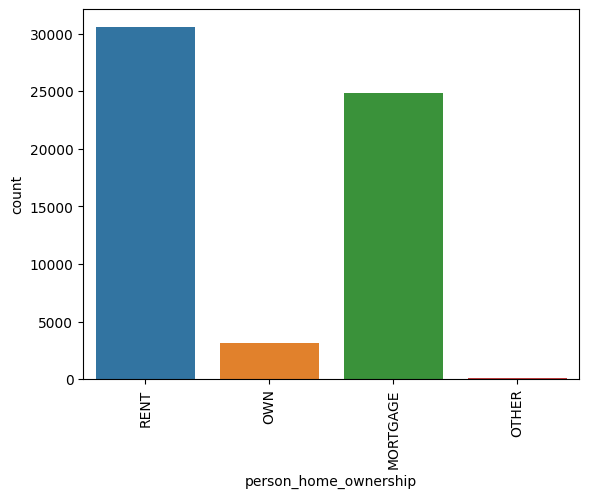

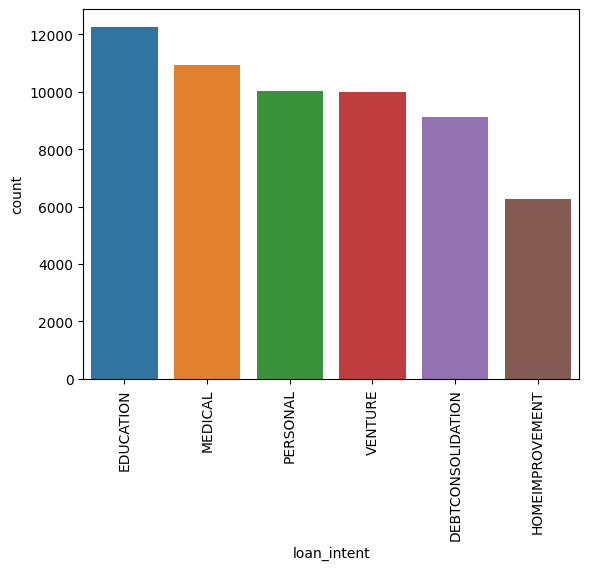

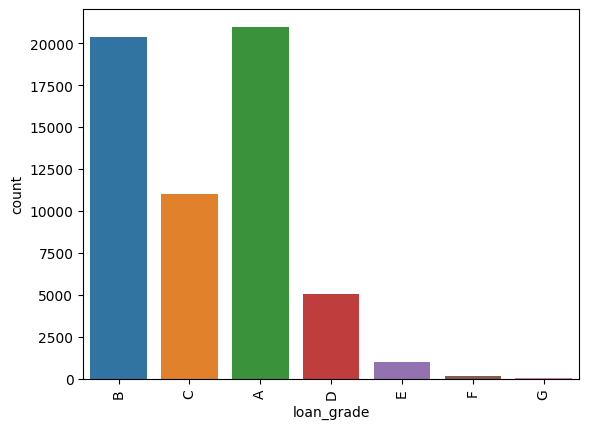

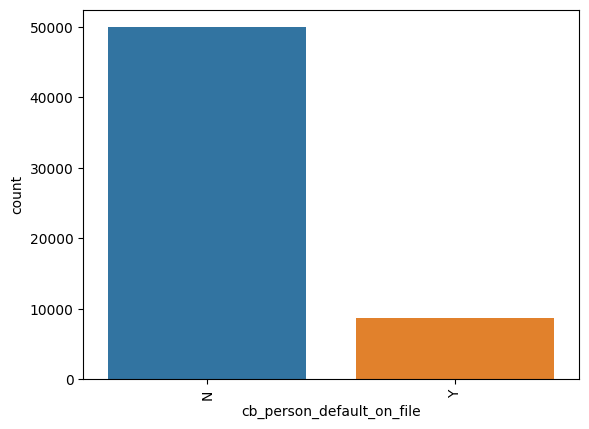

In [12]:
cat_features = train.select_dtypes(include='object').columns

for i in range(len(cat_features)):
    sns.countplot(x=cat_features[i], data=train)
    plt.xticks(rotation=90)
    plt.show()

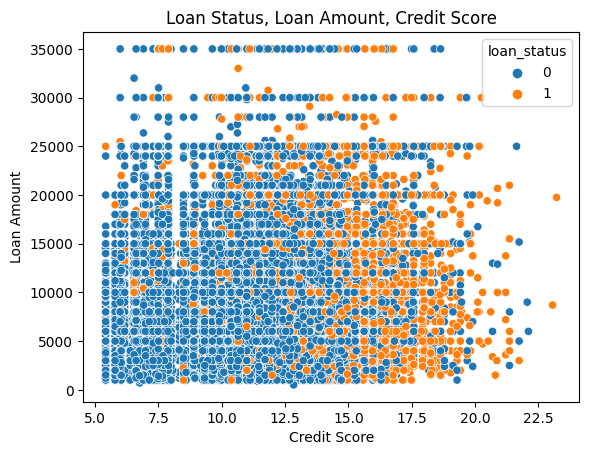

In [13]:
sns.scatterplot(x=train['loan_int_rate'], y= train['loan_amnt'], hue= train['loan_status'])
plt.title("Loan Status, Loan Amount, Credit Score")
plt.xlabel("Credit Score")
plt.ylabel("Loan Amount")
plt.show()

# Train, test, slit and other

In [14]:
tempt_train = train[['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']]
tempt_test = test[['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']]

In [15]:
for i in tempt_train.columns:
    tempt_train[i+'+log'] = (tempt_train[i]+1).transform(np.log)
    tempt_test[i+'+log'] =(tempt_test[i]+1).transform(np.log)

    tempt_train[i+'+log1'] = (tempt_train[i]+1).transform(np.log1p)
    tempt_test[i+'+log1'] =(tempt_test[i]+1).transform(np.log1p)

    tempt_train[i+'+sqrt'] = (tempt_train[i]+1).transform(np.sqrt)
    tempt_test[i+'+sqrt'] =(tempt_test[i]+1).transform(np.sqrt)

In [16]:
output_df = PolynomialFeatures_labeled(tempt_train,2)
output_df_t = PolynomialFeatures_labeled(tempt_test,2)

In [17]:
tempt_train =  pd.concat([tempt_train.reset_index(drop=True), output_df], axis = 1)
tempt_test = pd.concat([tempt_test.reset_index(drop=True), output_df_t], axis = 1)
tempt_train.shape, tempt_test.shape

((58645, 463), (39098, 463))

In [18]:
tempt_train = variance_threshold(tempt_train,0.2)
list_name = (tempt_train.columns)
tempt_test = tempt_test[list_name]

tempt_train.shape, tempt_test.shape

((58645, 402), (39098, 402))

In [19]:
PCA_obj = PCA(n_components=1)

PCA_obj.fit(tempt_train)

train['PCA'] = PCA_obj.transform(tempt_train)
test['PCA'] = PCA_obj.transform(tempt_test)

train.shape, test.shape

((58645, 14), (39098, 13))

In [20]:
y = train['loan_status']
X = train.drop(['id','loan_status'], axis =1)
tets = test.drop(['id'], axis =1)

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size = 0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((35187, 12), (35187,), (11729, 12), (11729,), (11729, 12), (11729,))

In [21]:
ord_cat=[
        ['N', 'Y'],
        ['B', 'C', 'A', 'D', 'E', 'F', 'G']
        ]
ohe_columns =['loan_intent', 'person_home_ownership']
ord_columns = ['cb_person_default_on_file', 'loan_grade']
num_columns = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
               'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']

In [22]:
ohe_pipe = Pipeline(
    [
        (
            'imputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output =False)
        )
    ]
) 

ord_pipe = Pipeline(
    [
        (
            'imputer_before', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=ord_cat, 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('imputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['loan_intent', 'person_home_ownership']),
                                ('ord',
                                 Pipeline(steps=[('imputer_before',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  Ord...
                                                                             ['B',
                                                                              'C',
                                                                              'A',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['cb_person_default_on_file', 'loan_grade']),
                                ('num', StandardScaler(),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate', 'loan_percent_income',
                                  'cb_person_cred_hist_length'])])

# Optuna serch

In [23]:
def objective(trial):
    model = Pipeline([
                        ('preprocessor', preprocessor),
                        ('cat',catboost.CatBoostClassifier(
                            iterations=trial.suggest_int("iterations", 100, 1000),
                            learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
                            depth=trial.suggest_int("depth", 4, 10),
                            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
                            bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
                            random_strength=trial.suggest_float("random_strength", 1e-8, 10.0),
                            bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
                            od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
                            od_wait=trial.suggest_int("od_wait", 10, 50),
                    #         task_type="GPU",  # Add this line to enable CUDA support
                            verbose=False
                        ))])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-06 07:24:51,989] A new study created in memory with name: no-name-a45c8ffb-75eb-443e-87f1-c68e80e76ca4
[I 2024-10-06 07:25:00,381] Trial 0 finished with value: 0.9396367976809618 and parameters: {'iterations': 244, 'learning_rate': 0.0018998186304002593, 'depth': 10, 'l2_leaf_reg': 0.04357488534379391, 'bootstrap_type': 'Bayesian', 'random_strength': 8.650063739792468, 'bagging_temperature': 9.453317193137803, 'od_type': 'IncToDec', 'od_wait': 48}. Best is trial 0 with value: 0.9396367976809618.
[I 2024-10-06 07:25:04,584] Trial 1 finished with value: 0.9438144769375053 and parameters: {'iterations': 600, 'learning_rate': 0.006849550972118231, 'depth': 4, 'l2_leaf_reg': 1.0721917280156098e-05, 'bootstrap_type': 'Bayesian', 'random_strength': 4.420224357799903, 'bagging_temperature': 1.966472925110655, 'od_type': 'IncToDec', 'od_wait': 50}. Best is trial 1 with value: 0.9438144769375053.
[I 2024-10-06 07:25:13,812] Trial 2 finished with value: 0.939551538920624 and parameters

Number of finished trials: 5
Best trial:
  Value: 0.9530224230539688
  Params: 
    iterations: 863
    learning_rate: 0.07244897265424706
    depth: 7
    l2_leaf_reg: 0.0001660062144471648
    bootstrap_type: Bayesian
    random_strength: 8.500650701603465
    bagging_temperature: 2.368379502295074
    od_type: IncToDec
    od_wait: 40


              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.90      0.73      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



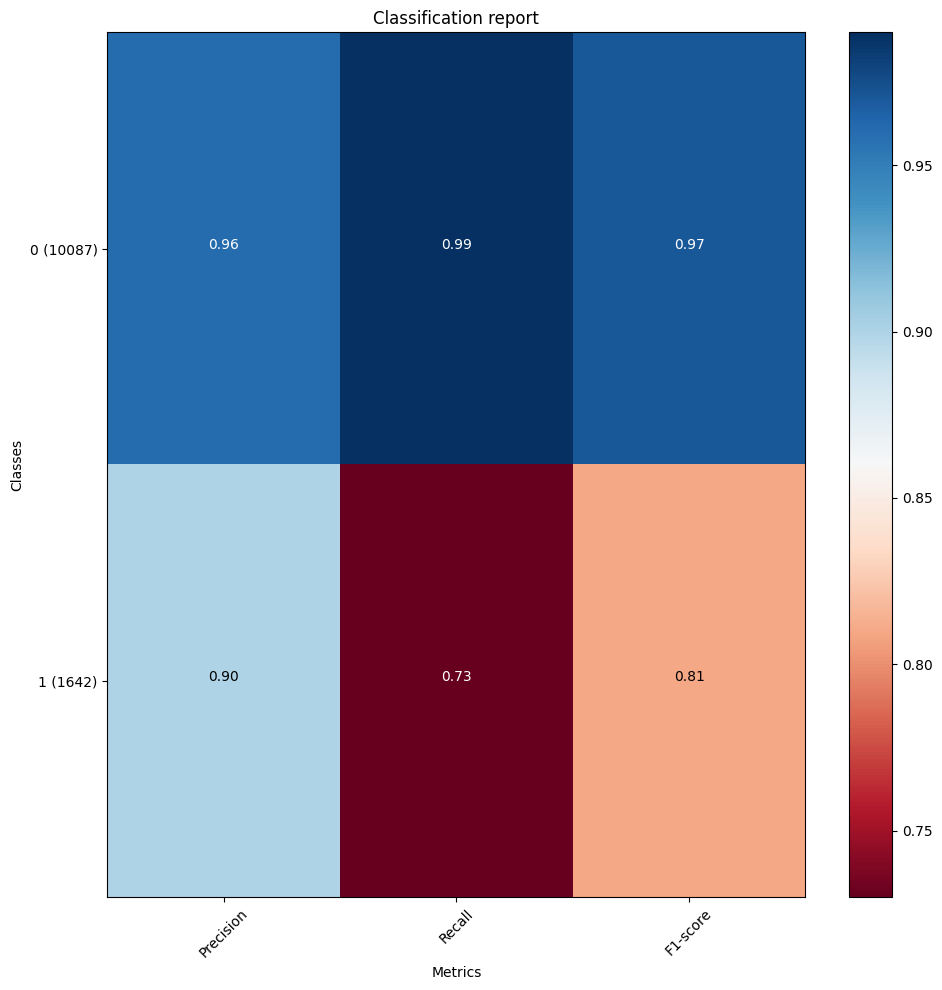

In [24]:
ct_best = study.best_params
model = model = Pipeline([
                        ('preprocessor', preprocessor),
                        ('cat',catboost.CatBoostClassifier(**ct_best, verbose = 0))])
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
clf =classification_report(y_test, y_pred)
plot_classification_report(clf)
print(clf)

In [25]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter' : False,
#         'device': 'gpu',  # Add this line to enable CUDA support
#         'gpu_device_id': 0  # Specify the GPU device ID (optional)
    }

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('lgbm', lgb.LGBMClassifier(**param, verbose = -1))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-06 07:26:02,933] A new study created in memory with name: no-name-e93b0ad2-02eb-4bc4-a859-b8dc67803142
[I 2024-10-06 07:26:05,638] Trial 0 finished with value: 0.953875010657345 and parameters: {'lambda_l1': 0.011333926983039193, 'lambda_l2': 0.7499077458270644, 'num_leaves': 167, 'feature_fraction': 0.8705845113517781, 'bagging_fraction': 0.7840213413558595, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 0 with value: 0.953875010657345.
[I 2024-10-06 07:26:07,754] Trial 1 finished with value: 0.9529371642936312 and parameters: {'lambda_l1': 4.961478019685535e-07, 'lambda_l2': 4.421169477879318e-05, 'num_leaves': 176, 'feature_fraction': 0.7597382934951318, 'bagging_fraction': 0.6167128391301048, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 0 with value: 0.953875010657345.
[I 2024-10-06 07:26:09,557] Trial 2 finished with value: 0.9545570807400461 and parameters: {'lambda_l1': 7.25766860831837e-05, 'lambda_l2': 0.003388475659621454, 'num_leaves': 99

Number of finished trials: 5
Best trial:
  Value: 0.9550686333020718
  Params: 
    lambda_l1: 4.660843761751874
    lambda_l2: 3.6106087265944745e-08
    num_leaves: 252
    feature_fraction: 0.7828376705093205
    bagging_fraction: 0.7704615359620665
    bagging_freq: 1
    min_child_samples: 41


              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.90      0.74      0.81      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.86      0.89     11729
weighted avg       0.95      0.95      0.95     11729



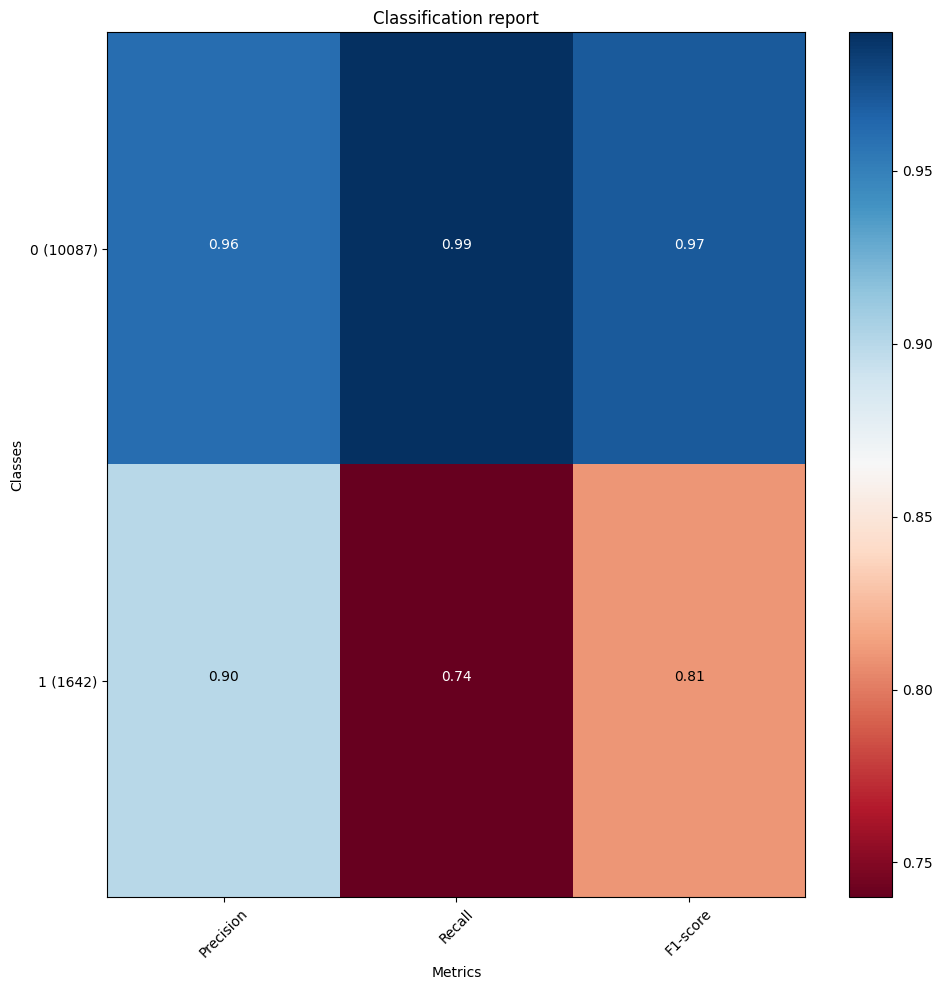

In [26]:
lgb_best = study.best_params
model = Pipeline([
        ('preprocessor', preprocessor),
        ('lgbm',lgb.LGBMClassifier(**lgb_best, verbose = -1))])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
clf =classification_report(y_test, y_pred)
plot_classification_report(clf)
print(clf)

In [27]:
def objective(trial):
    param = {
        "xgb__verbosity": 0,
        "xgb__objective": "binary:logistic",
#         "xgb__tree_method": "gpu_hist",
        "xgb__booster": trial.suggest_categorical("xgb__booster", ["gbtree", "gblinear", "dart"]),
        "xgb__lambda": trial.suggest_float("xgb__lambda", 1e-8, 1.0, log=True),
        "xgb__alpha": trial.suggest_float("xgb__alpha", 1e-8, 1.0, log=True),
        "xgb__subsample": trial.suggest_float("xgb__subsample", 0.2, 1.0),
        "xgb__colsample_bytree": trial.suggest_float("xgb__colsample_bytree", 0.2, 1.0),
    }

    if param["xgb__booster"] in ["gbtree", "dart"]:
        param["xgb__max_depth"] = trial.suggest_int("xgb__max_depth", 3, 9, step=2)
        param["xgb__min_child_weight"] = trial.suggest_int("xgb__min_child_weight", 2, 10)
        param["xgb__eta"] = trial.suggest_float("xgb__eta", 1e-8, 1.0, log=True)
        param["xgb__gamma"] = trial.suggest_float("xgb__gamma", 1e-8, 1.0, log=True)
        param["xgb__grow_policy"] = trial.suggest_categorical("xgb__grow_policy", ["depthwise", "lossguide"])

    if param["xgb__booster"] == "dart":
        param["xgb__sample_type"] = trial.suggest_categorical("xgb__sample_type", ["uniform", "weighted"])
        param["xgb__normalize_type"] = trial.suggest_categorical("xgb__normalize_type", ["tree", "forest"])
        param["xgb__rate_drop"] = trial.suggest_float("xgb__rate_drop", 1e-8, 1.0, log=True)
        param["xgb__skip_drop"] = trial.suggest_float("xgb__skip_drop", 1e-8, 1.0, log=True)

    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ("xgb", xgb.XGBClassifier( n_estimators=100))#tree_method="gpu_hist", gpu_id=0,
                    ])
    pipe.set_params(**param)
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

# Create an Optuna study
study = optuna.create_study(direction="maximize")

# Run the optimization
study.optimize(objective, n_trials=5, timeout=600)

# Print the results
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-06 07:26:15,205] A new study created in memory with name: no-name-f3fce38f-fdf5-4746-a3a9-0705bdfc1154
[I 2024-10-06 07:26:16,120] Trial 0 finished with value: 0.9051922585045613 and parameters: {'xgb__booster': 'gblinear', 'xgb__lambda': 2.7749769673527012e-08, 'xgb__alpha': 2.2951579753307707e-08, 'xgb__subsample': 0.3744603060773751, 'xgb__colsample_bytree': 0.8238611647466692}. Best is trial 0 with value: 0.9051922585045613.
[I 2024-10-06 07:27:05,440] Trial 1 finished with value: 0.8601756330462955 and parameters: {'xgb__booster': 'dart', 'xgb__lambda': 1.8343226544241283e-07, 'xgb__alpha': 0.0006175128559916365, 'xgb__subsample': 0.5352408014152881, 'xgb__colsample_bytree': 0.8335855895600124, 'xgb__max_depth': 3, 'xgb__min_child_weight': 9, 'xgb__eta': 5.05735461343174e-07, 'xgb__gamma': 0.94082062966129, 'xgb__grow_policy': 'lossguide', 'xgb__sample_type': 'uniform', 'xgb__normalize_type': 'forest', 'xgb__rate_drop': 0.0007244398369580096, 'xgb__skip_drop': 2.1940314

Number of finished trials:  5
Best trial:
  Value: 0.9516582828885668
  Params: 
    xgb__booster: gbtree
    xgb__lambda: 3.36626517228302e-05
    xgb__alpha: 0.0034935870261626825
    xgb__subsample: 0.9795185181211146
    xgb__colsample_bytree: 0.8274380204651466
    xgb__max_depth: 9
    xgb__min_child_weight: 10
    xgb__eta: 0.38583582512612447
    xgb__gamma: 0.024533191236184738
    xgb__grow_policy: lossguide


              precision    recall  f1-score   support

           0       0.86      0.88      0.87     10089
           1       0.14      0.11      0.12      1640

    accuracy                           0.78     11729
   macro avg       0.50      0.50      0.50     11729
weighted avg       0.76      0.78      0.77     11729



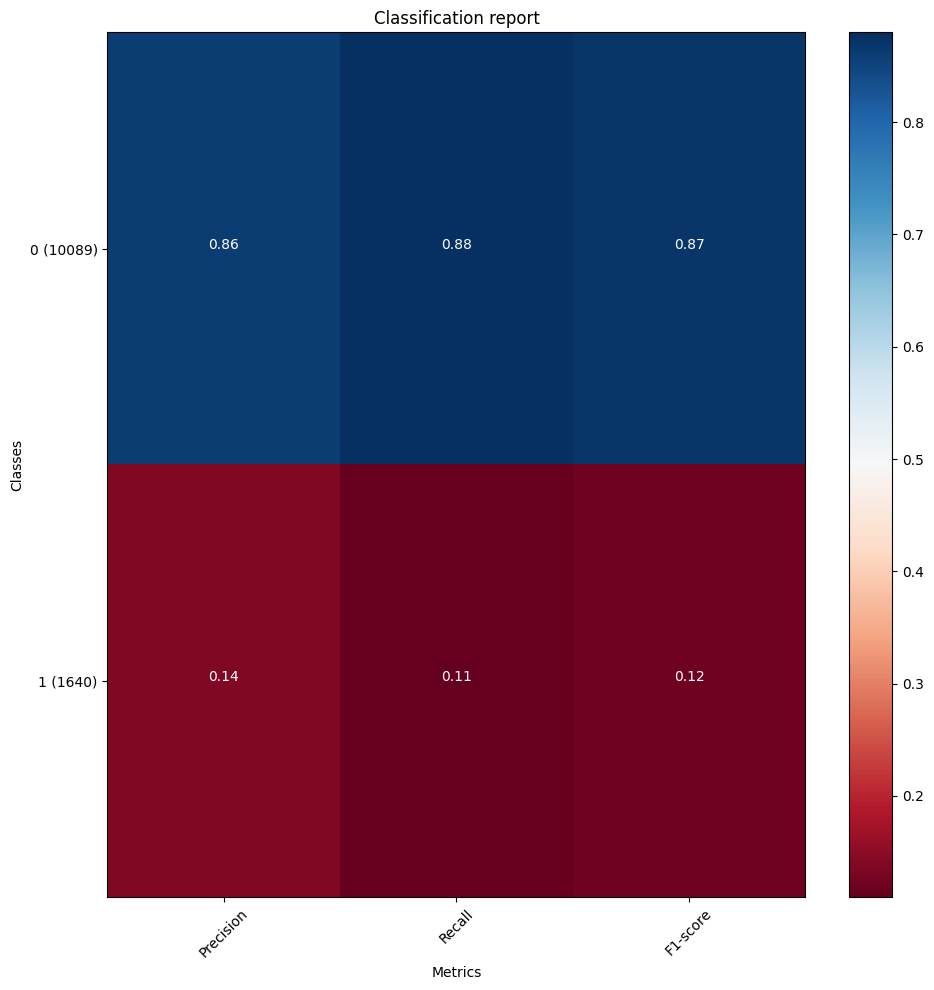

In [28]:
xgb_best = study.best_params
model = Pipeline([
        ('preprocessor', preprocessor),
        ("xgb", xgb.XGBClassifier(**xgb_best))#tree_method="gpu_hist", gpu_id=0,
                    ])
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
clf =classification_report(y_val, y_pred)
plot_classification_report(clf)
print(clf)

In [29]:
def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 10, 100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    # Create a Random Forest classifier with the suggested hyperparameters
    clf = Pipeline([
        ('preprocessor', preprocessor),
        ('rf', RandomForestClassifier(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf))])

    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Evaluate the classifier on the validation data
    y_pred = clf.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    # Return the negative accuracy as the objective value to minimize
    return -accuracy

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Run the optimization
study.optimize(objective, n_trials=5)

# Print the best hyperparameters and the corresponding accuracy
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", -study.best_value)

[I 2024-10-06 07:28:48,661] A new study created in memory with name: no-name-2b9a633c-96d3-49c7-b92e-6120113c73d5
[I 2024-10-06 07:28:50,335] Trial 0 finished with value: -0.9494415551197886 and parameters: {'n_estimators': 36, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.9494415551197886.
[I 2024-10-06 07:28:53,835] Trial 1 finished with value: -0.9473100861113479 and parameters: {'n_estimators': 79, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.9494415551197886.
[I 2024-10-06 07:28:56,965] Trial 2 finished with value: -0.9437292181771677 and parameters: {'n_estimators': 99, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: -0.9494415551197886.
[I 2024-10-06 07:28:58,466] Trial 3 finished with value: -0.9452638758632449 and parameters: {'n_estimators': 45, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 0 with valu

Best hyperparameters: {'n_estimators': 36, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}
Best accuracy: 0.9494415551197886


              precision    recall  f1-score   support

           0       0.86      0.89      0.88     10089
           1       0.14      0.11      0.12      1640

    accuracy                           0.78     11729
   macro avg       0.50      0.50      0.50     11729
weighted avg       0.76      0.78      0.77     11729



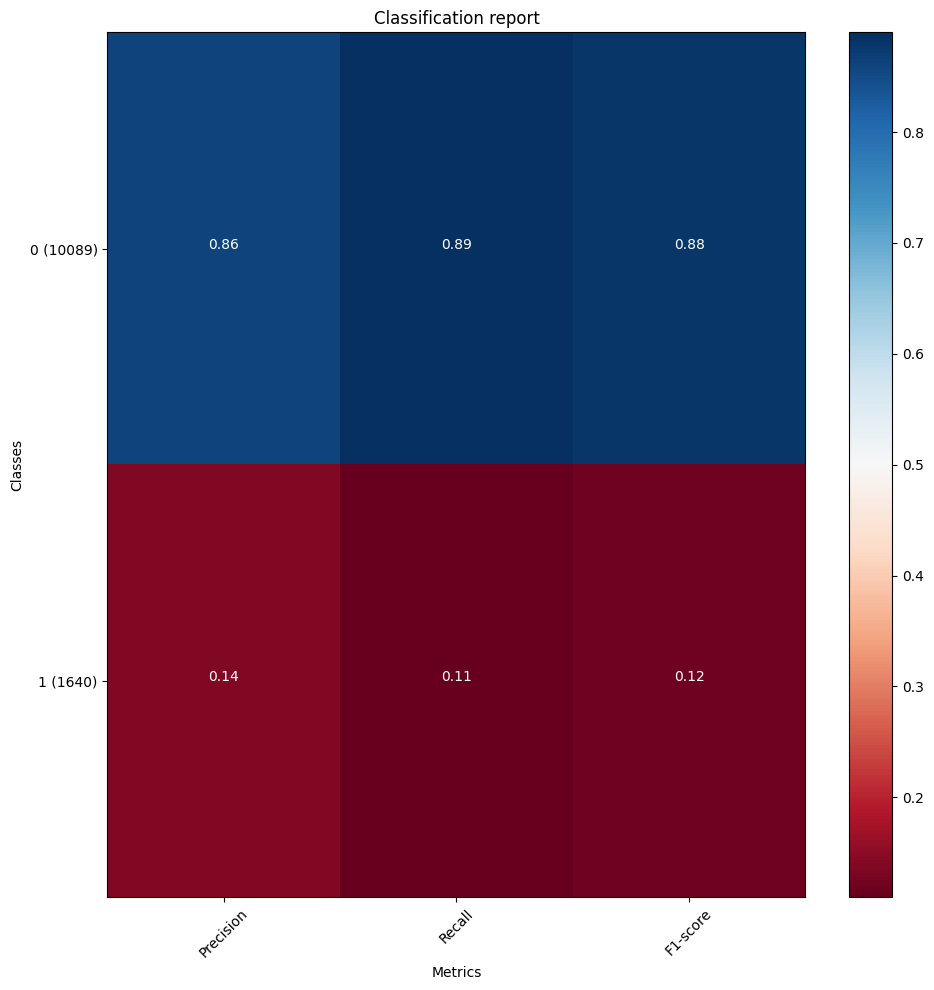

In [30]:
rf_best = study.best_params
model = Pipeline([
        ('preprocessor', preprocessor),
        ("rf", RandomForestClassifier(**rf_best))
                    ])
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
clf =classification_report(y_val, y_pred)
plot_classification_report(clf)
print(clf)

# Staking model

In [31]:

clf1 =  Pipeline(steps=[('preprocessor', preprocessor),
                        ('cat', CatBoostClassifier(**ct_best, verbose=0))])


clf2 =  Pipeline(steps=[('preprocessor', preprocessor), 
                    ('lgbm', lgb.LGBMClassifier(**lgb_best, verbose = -1))])

clf3 =  Pipeline(steps=[('preprocessor', preprocessor),
                    ('xgb', xgb.XGBClassifier(**xgb_best))])

clf4 =  Pipeline(steps=[('preprocessor', preprocessor),
                    ('rf', RandomForestClassifier(**rf_best))])

clf5 =  Pipeline(steps=[('preprocessor', preprocessor),
                    ('calib1', CalibratedClassifierCV(CatBoostClassifier(**ct_best, verbose=0), cv=KFold(n_splits=5)))])

clf6 =  Pipeline(steps=[('preprocessor', preprocessor),
                    ('calib2', CalibratedClassifierCV(xgb.XGBClassifier(**xgb_best), cv=KFold(n_splits=5)))])


stack_classifier = StackingCVClassifier(classifiers=[clf1,clf2, clf3, clf4, clf5, clf6] ,
                                  shuffle=False, use_probas=True, cv=5,
                                  meta_classifier=CatBoostClassifier(**ct_best, verbose=0))

classifiers = {"cat": clf1,
               "lgb": clf2,
               "xgb": clf3,
               'rf' : clf4,
               'calib': clf5,
               'calib2': clf6,
               "Stack": stack_classifier}

In [32]:
results = pd.DataFrame()

# Add target values to the results DataFrame
results['Target'] = y_test

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    results[name] = y_pred

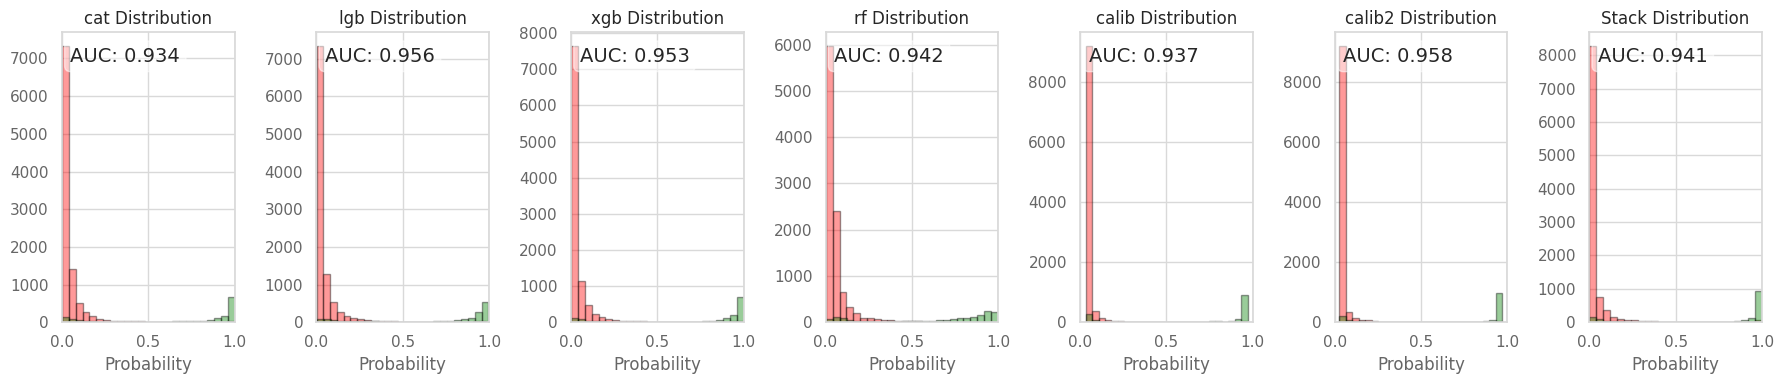

In [33]:
# Plot
sns.set(font_scale=1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85", "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4", 'ytick.color': '0.4'})

f, ax = plt.subplots(figsize=(18, 4), nrows=1, ncols=7)  # Create 7 subplots

for i, (name, _) in enumerate(classifiers.items()):
    y_pred = results[name]
    auc = roc_auc_score(y_test, y_pred)
    textstr = f"AUC: {auc:.3f}"

    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[name], hist=True, kde=False, bins=int(25), color='red', hist_kws={'edgecolor': 'black'}, ax=ax[i])

    true_pred = results[results["Target"] == 1]
    sns.distplot(true_pred[name], hist=True, kde=False, bins=int(25), color='green', hist_kws={'edgecolor': 'black'}, ax=ax[i])

    ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    ax[i].set_title(f"{name} Distribution")
    ax[i].set_xlim(0, 1)
    ax[i].set_xlabel("Probability")

plt.tight_layout()
plt.savefig("Probability Distribution for each Classifier.png", dpi=1080)

In [34]:
probs = pd.DataFrame()


for name, clf in classifiers.items():
    y_pred = clf.predict_proba(test)[:, 1]
    probs[name] = y_pred
probs.head(5)

,cat,lgb,xgb,rf,calib,calib2,Stack
0,0.999922,0.980083,0.999878,0.892712,0.967861,0.969898,0.999690
1,0.016737,0.010382,0.014019,0.022333,0.036356,0.028656,0.008413
2,0.989369,0.581633,0.573530,0.681861,0.952969,0.842544,0.933915
3,0.005849,0.007213,0.005665,0.031224,0.035613,0.027772,0.002397
4,0.089596,0.083336,0.045978,0.203006,0.054050,0.042768,0.088237


# Submit

In [35]:
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sub['loan_status'] = probs['Stack']
sub

,id,loan_status
0,58645,0.999690
1,58646,0.008413
2,58647,0.933915
3,58648,0.002397
4,58649,0.088237
...,...,...
39093,97738,0.102919
39094,97739,0.000656
39095,97740,0.003447
39096,97741,0.047861


In [36]:
sub.to_csv('submission.csv', index=False)